In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

# Time parameters
T = 10.0
dt = 0.01
t = np.arange(0, T, dt)

# Nonlinear system: m*x'' + c(v)*v + k(x)*x = d(t)
def nonlinear_system(t, y, d_func):
    x, v = y
    d = d_func(t)
    m = 1.0
    c = 0.5 + 0.1 * v**2  # Nonlinear damping
    k = 2.0 + 0.5 * x**2  # Nonlinear spring
    dxdt = v
    dvdt = (d - c * v - k * x) / m
    return [dxdt, dvdt]

def generate_trajectory(d_func):
    sol = solve_ivp(fun=lambda t, y: nonlinear_system(t, y, d_func),
                    t_span=(0, T), y0=[0.0, 0.0], t_eval=t, method='RK45')
    return sol.y.T

# Generate dataset
n_samples = 200
X, Y = [], []
for _ in range(n_samples):
    u = np.random.randn(len(t)) * 0.5
    d_func = lambda t_val: np.interp(t_val, t, u)
    traj = generate_trajectory(d_func)
    X.append(u)
    Y.append(traj[:, 0])  # output: position x(t)

X = np.array(X)
Y = np.array(Y)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

# Train model
model = SimpleNN(len(t))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

for epoch in range(500):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()

print("Final training loss:", loss.item())

# Estimate worst-case gain of learned model
def empirical_gain(model, n_trials=500):
    max_gain = 0.0
    for _ in range(n_trials):
        d = np.random.randn(len(t))
        d_norm = np.linalg.norm(d)
        d_unit = d / (d_norm + 1e-8)
        with torch.no_grad():
            d_tensor = torch.tensor(d_unit[None, :], dtype=torch.float32)
            y = model(d_tensor).numpy().squeeze()
        gain = np.linalg.norm(y) / (np.linalg.norm(d_unit) + 1e-8)
        max_gain = max(max_gain, gain)
    return max_gain

gamma_empirical = empirical_gain(model)
print(f"Empirical worst-case gain of the learned model: {gamma_empirical:.3f}")


Final training loss: 1.50017813211889e-05
Empirical worst-case gain of the learned model: 1.514


6.049667584646656
1062.0295474085103
1062.0295474085103


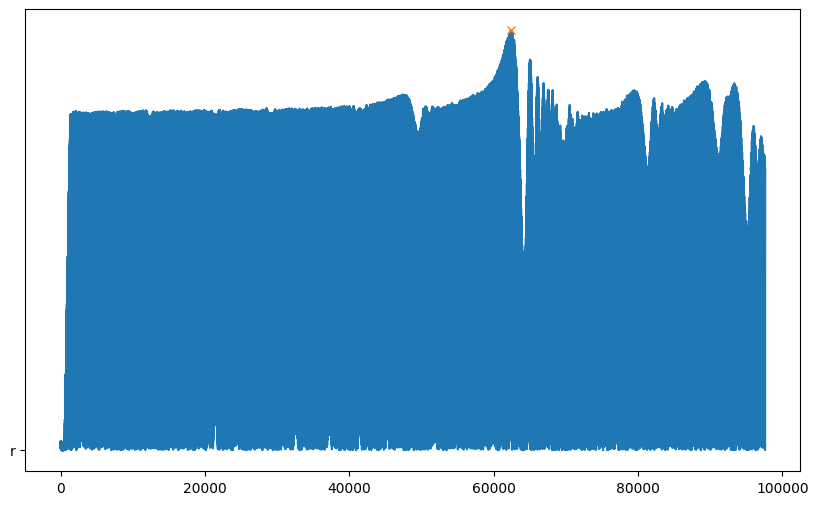

In [35]:
from crnn.data_io import load_data
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

dataset_dir = '/Users/jack/datasets/F16/in-distribution/processed'
input_names = ['u_1']
output_names = ['y_1', 'y_2', 'y_3']

data = load_data(input_names, output_names, 'train', dataset_dir)

d_raw = data.d[0]



def peak_norm(d:NDArray[np.float64])-> np.float64:
    return np.max(np.linalg.norm(d, axis=1))

def l2_norm(d:NDArray[np.float64]) -> np.float64:
    return np.sqrt(np.sum(np.linalg.norm(d, axis=1)**2))

def l2rho_norm(d:NDArray[np.float64], rho:np.float64 = 1.0) -> np.float64:
    return np.sqrt(np.sum([rho**(-2*k) * np.linalg.norm(d_k)**2 for k, d_k in enumerate(d)]))

    

print(peak_norm(d_raw))
print(l2_norm(d_raw))
print(l2rho_norm(d_raw,1))

fig, ax = plt.subplots(figsize=(10,6))
pos = np.argmax(np.linalg.norm(d_raw,axis=1))
ax.plot(np.linalg.norm(d_raw,axis=1))
ax.plot(pos, peak_norm(d_raw), 'x', 'r')


97629


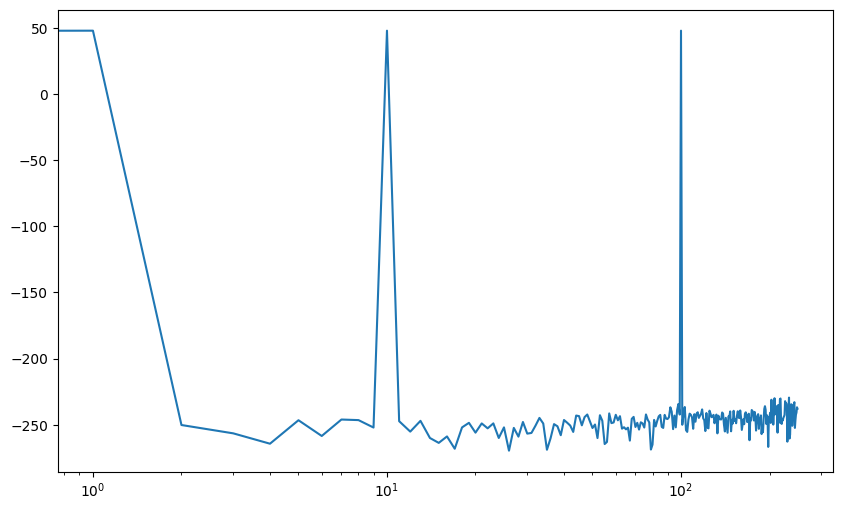

In [125]:
print(len(d_raw))
h, T = 500, 1
d = d_raw[:h]
t = np.linspace(0,T-T/h,h)
sin_ = lambda t, f: np.sin(2*np.pi*f*t)
cos_ = lambda t, f: np.cos(2*np.pi*f*t)
d = sin_(t,1) + sin_(t,100) + cos_(t,10) 
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(d)

# D_fft = np.fft.fft(d)
# freqs = np.fft.fftfreq(h,d = t[1]-t[0] )
# print(len(freqs))
# print(freqs)

D = np.zeros_like(d, dtype=complex)
for k in range(h):
    D[k] = np.sum([d_n * np.exp(-2j*np.pi*k/h*n) for (n, d_n)  in enumerate(d)])

# np.linalg.norm(D - D_fft,2)
dt = t[1]-t[0]
# print(dt)
freq = np.array([k/(h*dt) for k in range(h)])
# print(freq)
# print(len(freq))
ax.semilogx(freq[:h//2],20*np.log10(np.abs(D[:h//2])))






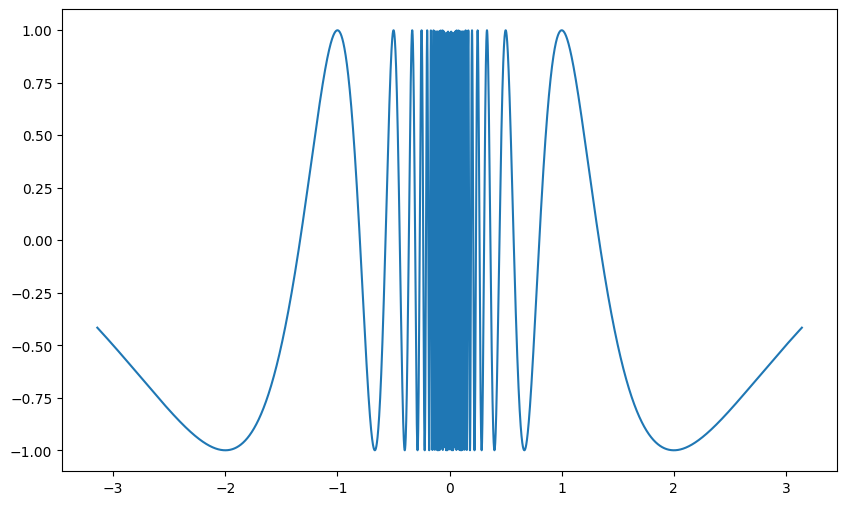

In [48]:
w_n = lambda n: np.exp(-2j*np.pi/n)
n = np.linspace(-np.pi,np.pi, 10000)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n,w_n(n))

In [51]:
f = 1/(2*np.pi)
f

0.15915494309189535

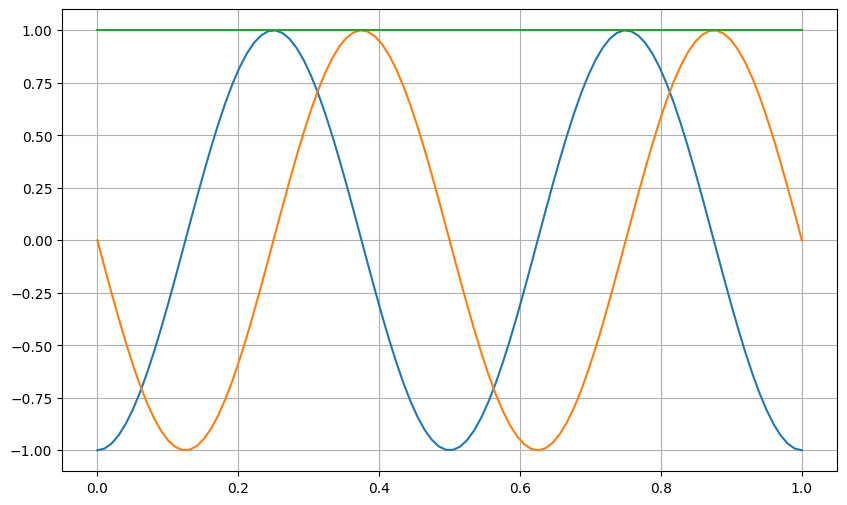

In [74]:


# exp_ = lambda t, f: np.cos(2*np.pi*t*f)+1j*np.sin(2*np.pi*t*f)
exp2_ = lambda t,f: -np.exp(2*np.pi*1j*f*t)
f = 1
t = np.linspace(0,1,100)
fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(t, np.real(exp_(t,f)))
# ax.plot(t, np.imag(exp_(t,f)))

ax.plot(t, np.real(exp2_(t,2)))
ax.plot(t, np.imag(exp2_(t,2)))
ax.plot(t, np.abs(exp2_(t,2)))
ax.grid()


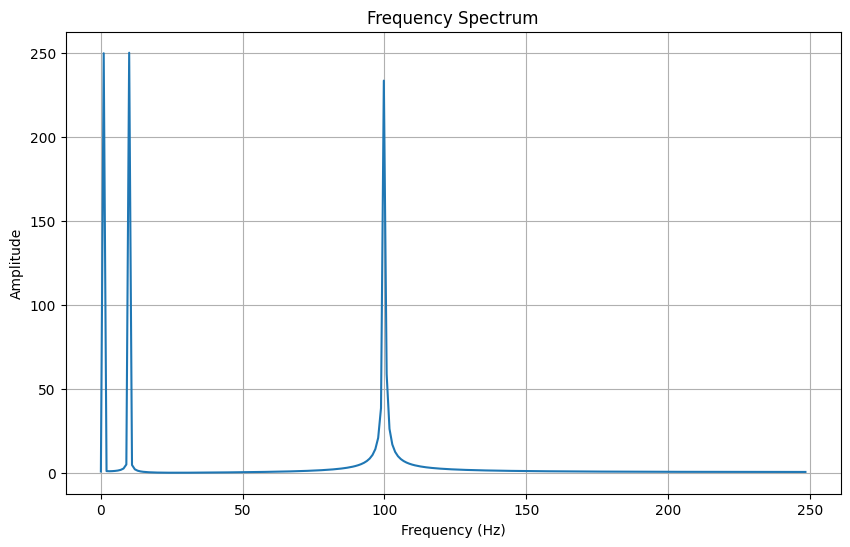

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# your original signal
h = 500
t = np.linspace(0,1,h)
sin_ = lambda t, f: np.sin(2*np.pi*f*t)
cos_ = lambda t, f: np.cos(2*np.pi*f*t)
d = sin_(t,1) + sin_(t,100) + cos_(t,10)

# compute the FFT
D_fft = np.fft.fft(d)
freqs = np.fft.fftfreq(h, d=(t[1] - t[0]))  # calculate the frequency bins

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(freqs[:h//2], np.abs(D_fft[:h//2]))  # only plot the positive frequencies
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency Spectrum')
plt.grid(True)
plt.show()